In [16]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import stats
from skimage.transform import resize
from scipy.ndimage import rotate # could use skimage rotate
import sys
import time
from IPython import display
from astropy.io import fits 
from scipy.ndimage import rotate
import glob
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import os
import shutil
from pathlib import Path

In [17]:
def show_images(images, num):
    """
    Visualising the images
    """
    
    cols = 6
    rows = (num+cols-1)//cols
    plt.figure(figsize=(cols*4, rows*4))
    for i in range(num):
        ax = plt.subplot(rows, cols, i+1)
        image = images[i]
        plt.imshow(image, cmap='inferno', origin='lower')
        plt.axis('off')
    plt.show() 

In [18]:
def prepare(files):
    
    """
    Performs preprocessing including sigma clipping, normalisation and removing nans.
    """
    np.seterr(divide='ignore', invalid='ignore')
    array = np.empty([len(files), 128, 128])
    sigma = 1.5
    pbar = tqdm(total=len(array))

    i = 0
    while i < len(files):
        image = fits.open(files[i], ignore_missing_end=True)[0].data.squeeze() 

        image = 2*((image-np.min(image))/np.ptp(image))-1
        image = np.where(np.isnan(image), 0, image)
        mean, median, std = stats.sigma_clipped_stats(image, sigma=sigma)
        image[image < median+sigma*std] = -1
        
        array[i] = image
        
        pbar.update(1)
        i+=1
        
    return array

In [21]:
files = []

i = 0
while i < 9521:
    
    files.append(r"Raw Data\Cuts\cut{}.fits".format(i))
    
    i+=1

In [22]:
im = prepare(files)

  0%|          | 0/9521 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'Raw Data\\Cuts\\cut9520.fits'

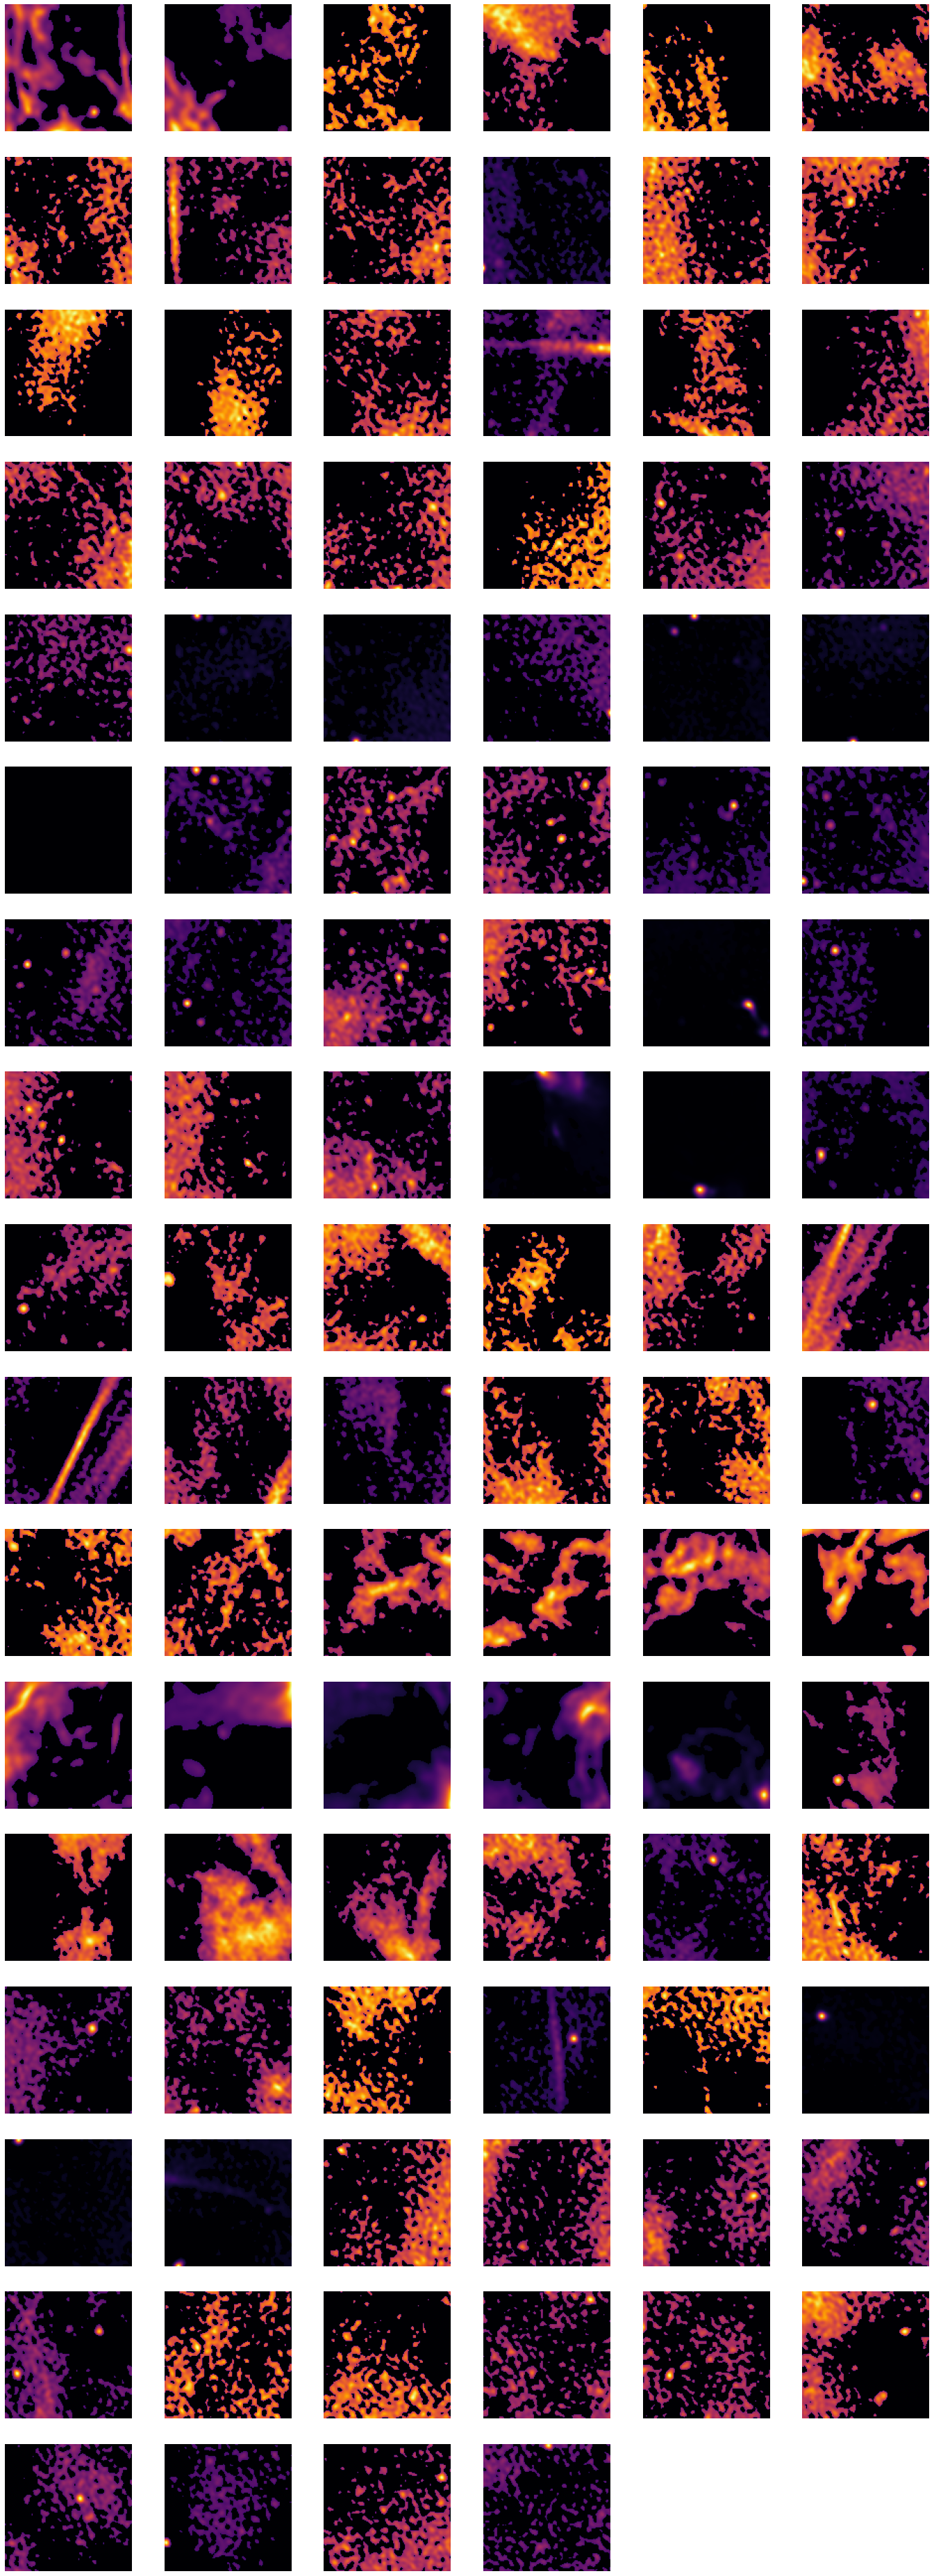

In [23]:
show_images(im[2000:], 100)

In [24]:
ims = im[..., tf.newaxis].astype('float32')

In [25]:
print(np.max(ims), np.min(ims))
print(ims.shape)

1.0 -1.0
(9520, 128, 128, 1)


In [26]:
input_shape = ims.shape[1:]

model = tf.keras.models.load_model('saved_models/4_layer_model_tuned')

In [28]:
#separating filaments and non-filaments;

pbar = tqdm(total=len(ims))
i=0
while i < len(ims):
    pred = model.predict(ims[i][np.newaxis, ...])
    result = int(round(pred[0][0]))

    if result == 0:
        shutil.copyfile(r"Raw Data\Cuts\cut{}.fits".format(i), r"Raw Data\Not Filaments\cut{}.fits".format(i))
    else:
        shutil.copyfile(r"Raw Data\Cuts\cut{}.fits".format(i), r"Raw Data\Filaments\cut{}.fits".format(i))
    pbar.update(1)
    
    i+=1

  0%|          | 0/9520 [00:00<?, ?it/s]

In [105]:
preds = []
pbar = tqdm(total=100)
for i in range(100):
    pred = model.predict(ims[i][np.newaxis, ...])
    preds.append((int(round(pred[0][0]))))
    pbar.update(1)

  0%|          | 0/23391 [00:00<?, ?it/s]

In [11]:
results = np.zeros((86, 68))  #num of images in each column and each row as found in worksheet 0

In [12]:
f = 0
n = 0
pbar = tqdm(total=results.size)
while n < len(results[0]):   #length of rows
    m = 0
    while m < len(results.T[0]):  #length of column
        pred = model.predict(ims[f][np.newaxis, ...])
        results[m][n] = int(round(pred[0][0])) #works down each column, then progresses to the next column.
        pbar.update(1)
        m+=1
        f+=1
    n+=1

  0%|          | 0/5848 [00:00<?, ?it/s]

In [14]:
unique, counts = np.unique(results, return_counts=True)
dict(zip(unique, counts))

{0.0: 5189, 1.0: 659}

In [15]:
np.save(r"Data arrays\predictions.npy", results)